In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *


2024-01-23 19:55:47.524105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Max mutual information vs sampling density for different samples

In [15]:
from scipy.signal import resample

N_objects = 5000
noise_sigma = 1e-3
num_samples_list = [1, 4, 9, 16, 25, 36]
num_bootstrap_samples = 11
upsampling_factor = 16
max_epochs = 5000
confidence = 90
num_nyquist_samples = 16
object_names = ['white_noise', 'delta_uniform', '8_deltas_uniform']

# Fro debugging
# object_names = ['delta_uniform',]
# max_epochs = 1000
# num_nyquist_samples = 16

# num_samples_list = [1, 4, 9, 16]

upsampled_signal_length = upsampling_factor*num_nyquist_samples
objects_fn_delta = lambda : np.array([generate_random_object('delta', num_deltas=1, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_8_delta = lambda : np.array([generate_random_object('delta', num_deltas=8, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_white_noise = lambda : np.array([generate_random_object('white_noise', object_size=upsampled_signal_length) for i in range(N_objects)])


mi_by_object = {}
mi_by_object_hi = {}
mi_by_object_lo = {}
for name in object_names:
  print(name)
  mutual_information = []
  mi_hi = []
  mi_lo = []

  if name == 'delta_uniform':
    objects_fn = objects_fn_delta
  elif name == '8_deltas_uniform':
    objects_fn = objects_fn_8_delta
  else:
    objects_fn = objects_fn_white_noise

  # Find an optimal PSF for this object
  initial_kernel, initial_params, optimized_params, objects, _, _ = optimize_PSF_and_estimate_mi(
      objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length,
      max_epochs=max_epochs, )

  # compute the information with this psf when integrating over pixels of different sizes 
  for num_samples in tqdm(num_samples_list):


    runs = []
    for i in range(num_bootstrap_samples):

      # do the estimation
      scale_factor = 1000 # because these signals are 0-1 but pixel cnn is designed for photon counts
      test_objects = objects_fn()
      output_signals = conv_forward_model(optimized_params, test_objects,
                                                  integrate_output_signals=False, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length)
      
      # interpolate to higher resolution before integrating
      resampled_signal_length = num_samples * upsampling_factor

      resampled_output_signals = resample(output_signals, resampled_signal_length, axis=-1)
      # normalize to sum to 1
      resampled_output_signals = resampled_output_signals / np.sum(resampled_output_signals, axis=-1, keepdims=True)
      pixelated_signal = integrate_pixels(resampled_output_signals, num_samples)

      # amount of noise to add to the pixel depends on its area
      relative_sampling_area = num_nyquist_samples / num_samples
      pixel_variance = noise_sigma**2 * relative_sampling_area

      noisy_pixelated_signals = pixelated_signal + jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), pixelated_signal.shape) * np.sqrt(pixel_variance)

      fake_images = noisy_pixelated_signals.reshape(-1, int(np.sqrt(num_samples)), int(np.sqrt(num_samples))) * scale_factor
      mi_estimate = estimate_mutual_information(fake_images, gaussian_noise_sigma=float(np.sqrt(pixel_variance) * scale_factor), verbose=False, entropy_model='pixelcnn')                                                      
      print(mi_estimate)
      runs.append(mi_estimate)
    runs = np.array(runs)
    mutual_information.append(np.median(runs))
    mi_lo.append(np.percentile(np.array(runs), 100-confidence))
    mi_hi.append(np.percentile(np.array(runs), confidence))
  mi_by_object[name] = mutual_information
  mi_by_object_hi[name] = mi_hi
  mi_by_object_lo[name] = mi_lo

white_noise
initial loss -0.20848109544504848
computing optimized mi


 17%|█▋        | 1/6 [00:55<04:36, 55.28s/it]

0.006632493870844869


 33%|███▎      | 2/6 [02:02<04:09, 62.50s/it]

1.5366248936940297


 50%|█████     | 3/6 [02:54<02:52, 57.54s/it]

1.5967183577612045


 67%|██████▋   | 4/6 [03:42<01:47, 53.82s/it]

1.2773036025651223


 83%|████████▎ | 5/6 [04:42<00:55, 55.92s/it]

0.9334115275614744


100%|██████████| 6/6 [05:40<00:00, 56.72s/it]

0.7209773653577708
delta_uniform


initial loss -3.880581859625792
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.01% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 17%|█▋        | 1/6 [00:38<03:11, 38.23s/it]

0.09851112940658485


 33%|███▎      | 2/6 [01:20<02:42, 40.57s/it]

3.269507293279715


 50%|█████     | 3/6 [02:33<02:46, 55.35s/it]

1.9159931421983536


 67%|██████▋   | 4/6 [03:26<01:48, 54.30s/it]

0.972085648113594


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.68% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 83%|████████▎ | 5/6 [04:29<00:57, 57.68s/it]

0.948280975572422


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.27% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
100%|██████████| 6/6 [05:41<00:00, 56.86s/it]

0.7239875776958226
8_deltas_uniform


initial loss -2.9076369110528657
computing optimized mi


 17%|█▋        | 1/6 [00:35<02:55, 35.09s/it]

-0.01976099562646692


 33%|███▎      | 2/6 [01:15<02:32, 38.17s/it]

5.417616005976023


 50%|█████     | 3/6 [02:18<02:29, 49.70s/it]

5.136932038733974


 67%|██████▋   | 4/6 [03:08<01:39, 49.68s/it]

4.078317619968549


 83%|████████▎ | 5/6 [04:10<00:54, 54.22s/it]

2.8532947910139126


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.00% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
100%|██████████| 6/6 [05:05<00:00, 50.87s/it]

2.073305670194729


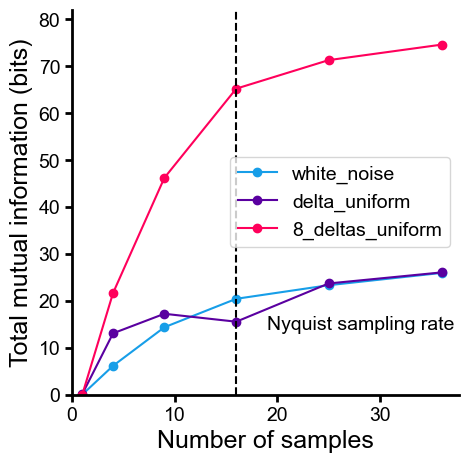

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for object_name, mutual_information in mi_by_object.items():
    total_mi = np.array(mutual_information) * np.array(num_samples_list)

    ax.plot(num_samples_list, total_mi, 'o-', label=object_name)
    ax.fill_between(num_samples_list, mi_by_object_lo[object_name] * np.array(num_samples_list), mi_by_object_hi[object_name] * np.array(num_samples_list), alpha=0.4)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])), xlim=(0, ax.get_xlim()[1]))

# plot a dashed line at the number of nyquist samples
ax.axvline(num_nyquist_samples, linestyle='--', color='k')
ax.text(num_nyquist_samples + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
ax.legend()

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'mi_vs_sampling_density' + '.pdf', transparent=True)


## Show transition behavior with different SNR levels

In [3]:
from scipy.signal import resample

N_objects = 5000
noise_sigma = 1e-3
num_samples_list = [1, 4, 9, 16, 25, 36]
num_bootstrap_samples = 1
upsampling_factor = 16
max_epochs = 5000
confidence = 90
num_nyquist_samples = 16
noise_sigmas_list = np.array([1e-4, 1e-3, 1e-2, 1e-1]) * 0.8

# Fro debugging
# object_names = ['delta_uniform',]
# max_epochs = 1000
# num_nyquist_samples = 16

# num_samples_list = [1, 4, 9, 16]

upsampled_signal_length = upsampling_factor*num_nyquist_samples
objects_fn_delta = lambda : np.array([generate_random_object('delta', num_deltas=1, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_white_noise = lambda : np.array([generate_random_object('white_noise', object_size=upsampled_signal_length) for i in range(N_objects)])


mi_by_snr_median = {}
mi_by_snr_hi = {}
mi_by_snr_lo = {}
for noise_sigma in noise_sigmas_list:
  noise_sigma = float(noise_sigma)
  print('noise sigma', noise_sigma)
  mutual_information = []
  mi_hi = []
  mi_lo = []

  objects_fn = lambda : np.array([generate_random_object('delta', num_deltas=8, object_size=upsampled_signal_length) for i in range(N_objects)])


  # Find an optimal PSF for this object
  initial_kernel, initial_params, optimized_params, objects, _, _ = optimize_PSF_and_estimate_mi(
      objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length,
      max_epochs=max_epochs, )

  # compute the information with this psf when integrating over pixels of different sizes 
  for num_samples in tqdm(num_samples_list):


    runs = []
    for i in range(num_bootstrap_samples):

      # do the estimation
      scale_factor = 1000 # because these signals are 0-1 but pixel cnn is designed for photon counts
      test_objects = objects_fn()
      output_signals = conv_forward_model(optimized_params, test_objects,
                                                  integrate_output_signals=False, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length)
      
      # interpolate to higher resolution before integrating
      resampled_signal_length = num_samples * upsampling_factor

      resampled_output_signals = resample(output_signals, resampled_signal_length, axis=-1)
      # normalize to sum to 1
      resampled_output_signals = resampled_output_signals / np.sum(resampled_output_signals, axis=-1, keepdims=True)
      pixelated_signal = integrate_pixels(resampled_output_signals, num_samples)

      # amount of noise to add to the pixel depends on its area
      relative_sampling_area = num_nyquist_samples / num_samples
      pixel_variance = noise_sigma**2 * relative_sampling_area

      noisy_pixelated_signals = pixelated_signal + jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), pixelated_signal.shape) * np.sqrt(pixel_variance)

      fake_images = noisy_pixelated_signals.reshape(-1, int(np.sqrt(num_samples)), int(np.sqrt(num_samples))) * scale_factor
      mi_estimate = estimate_mutual_information(fake_images, gaussian_noise_sigma=float(np.sqrt(pixel_variance) * scale_factor), verbose=False, entropy_model='pixelcnn')                                                      
      print(mi_estimate)
      runs.append(mi_estimate)
    runs = np.array(runs)
    mutual_information.append(np.median(runs))
    mi_lo.append(np.percentile(np.array(runs), 100-confidence))
    mi_hi.append(np.percentile(np.array(runs), confidence))
  mi_by_snr_median[noise_sigma] = mutual_information
  mi_by_snr_hi[noise_sigma] = mi_hi
  mi_by_snr_lo[noise_sigma] = mi_lo

noise sigma 8e-05
initial loss -6.007068342011207
computing optimized mi


2024-01-23 19:57:40.790932: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
 17%|█▋        | 1/6 [00:39<03:19, 39.82s/it]

0.3242218503027619


 33%|███▎      | 2/6 [01:43<03:36, 54.15s/it]

9.1578781025878


 50%|█████     | 3/6 [02:51<03:00, 60.21s/it]

8.756449243758594


 67%|██████▋   | 4/6 [03:50<01:59, 59.95s/it]

7.664760497440439


 83%|████████▎ | 5/6 [05:09<01:06, 66.64s/it]

6.0956650495860485


100%|██████████| 6/6 [06:36<00:00, 66.11s/it]

5.061172734349714
noise sigma 0.0008


initial loss -2.943549525220832
computing optimized mi


 17%|█▋        | 1/6 [00:33<02:48, 33.79s/it]

0.06596750242712089


 33%|███▎      | 2/6 [01:14<02:31, 37.85s/it]

5.760411787788475


 50%|█████     | 3/6 [02:31<02:47, 55.89s/it]

5.4735811606045885


 67%|██████▋   | 4/6 [03:32<01:55, 57.96s/it]

4.414785128159853


 83%|████████▎ | 5/6 [04:33<00:59, 59.01s/it]

3.0681585262596505


100%|██████████| 6/6 [05:30<00:00, 55.11s/it]

2.2674737011662405
noise sigma 0.008


initial loss -0.4413503434575131
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 1.61% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 17%|█▋        | 1/6 [00:31<02:37, 31.46s/it]

0.04647537887443622


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.03% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 33%|███▎      | 2/6 [01:31<03:14, 48.55s/it]

2.3404528939787084


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.50% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 50%|█████     | 3/6 [02:31<02:40, 53.64s/it]

2.42867308869859


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 1.63% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 67%|██████▋   | 4/6 [04:32<02:40, 80.32s/it]

2.040367243046393


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 3.11% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 83%|████████▎ | 5/6 [24:02<07:53, 473.27s/it]

1.2614419569975552


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 4.51% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
100%|██████████| 6/6 [42:48<00:00, 428.11s/it]

0.8977148288124893
noise sigma 0.08000000000000002


initial loss -0.006270708386767155
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 25.29% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
  0%|          | 0/6 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.02% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 17%|█▋        | 1/6 [15:21<1:16:49, 921.84s/it]

0.021276527000821197


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 10.58% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 33%|███▎      | 2/6 [43:48<1:32:14, 1383.58s/it]

0.34021147097203014


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 19.84% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 50%|█████     | 3/6 [1:06:02<1:08:03, 1361.05s/it]

0.30842217191984445


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 25.48% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


/tmp/ipykernel_836259/1474994870.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colormap = plt.cm.get_cmap('inferno')


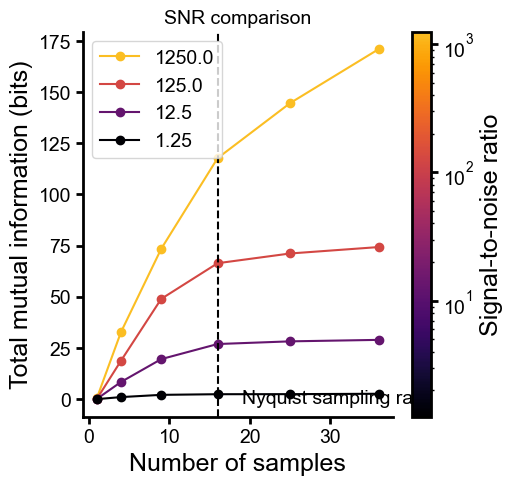

In [15]:
snrs = (1 / NUM_NYQUIST_SAMPLES) / np.array(noise_sigmas_list)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Define the start and end points--used so that high values aren't too light against white background
start, end = 0, 0.85
base_colormap = plt.cm.get_cmap('inferno')

from matplotlib.colors import LinearSegmentedColormap
# Create a new colormap from the portion of the original colormap
colormap = LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=base_colormap.name, a=start, b=end),
    base_colormap(np.linspace(start, end, 256))
)

colors = colormap(np.linspace(0, 1, len(noise_sigmas_list)))

for i, ((noise_sigma, mutual_information), snr) in enumerate(zip(mi_by_snr_median.items(), snrs)):

    total_mi = np.array(mutual_information) * np.array(num_samples_list)

    ax.plot(num_samples_list, total_mi,  'o-', color=colors[-i - 1], label=snr)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    # ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])))

# plot a dashed line at the number of nyquist samples
ax.axvline(num_nyquist_samples, linestyle='--', color='k')
ax.text(num_nyquist_samples + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
ax.legend()
ax.set(title='SNR comparison')



# Create a scalar mappable object with the colormap and the snrs range
norm = LogNorm(vmin=np.min(snrs), vmax=np.max(snrs))
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Signal-to-noise ratio')
